In [12]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel

from sklearn.preprocessing import LabelEncoder

import networkx as nx
import matplotlib.pyplot as plt

In [13]:
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [14]:
dataset = pd.read_csv("../data/train_simple.gzip", compression="gzip")
dataset.shape

In [15]:
cat_cols = ["region", "osm_city_nearest_name", "realty_type"]

for col in cat_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

In [16]:
dataset["floor"] = dataset["floor"].fillna(1)
dataset["city_population"] = dataset["city_population"].fillna(0)

In [17]:
dataset["price_type"] = dataset["price_type"].astype(bool)

In [18]:
dataset.isna().sum().sum()

0

#### Получение бинарного признака из reform_mean_year_building_500

In [19]:
import seaborn as sns

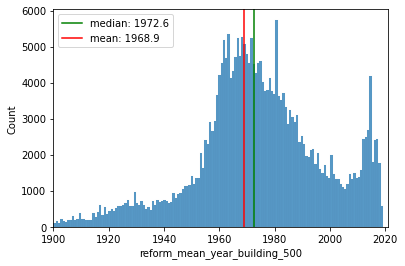

In [20]:
mean = dataset["reform_mean_year_building_500"].mean()
median = dataset["reform_mean_year_building_500"].median()
sns.histplot(dataset["reform_mean_year_building_500"])
plt.axvline(median, label=f"median: {median:.1f}", c='g')
plt.axvline(mean, label=f"mean: {mean:.1f}", c='r')
plt.xlim([1900, 2021])
plt.legend()
plt.show()

In [21]:
dataset["reform_mean_year_building_500_after_1991"] = dataset["reform_mean_year_building_500"].apply(lambda x: True if x > 1991 else False)
del dataset["reform_mean_year_building_500"]

dataset["reform_mean_year_building_500_after_1991"].value_counts()

False    220203
True      59589
Name: reform_mean_year_building_500_after_1991, dtype: int64

## **Описание задачи**

Предсказание цены коммерческой недвижимости. Оценка вручную занимает много времени (долгая оценка = задержка решения по выдаче кредита → можно потерять клиента), зато есть много данных по оценке стоимости недвижимости из объявлений в интернете. Предлагается сравнить эти 2 группы наблюдений.

* [Описание данных](https://russianhackers.notion.site/c666cd6d3d8c44adb79d73f69d3ee81a?v=2b1e857b3252422a87cd95cf51225ba0)
* [Описание исходной задачи](https://russianhackers.notion.site/6b142361271a42feb6581759a8c886e0)

### Step 1. Modeling a causal graph

In [115]:
target = "per_square_meter_price"
treatment = "reform_mean_year_building_500_after_1991" # Дома в радиусе 500 метров в среднем построены позже 1991 (распад СССР)

In [116]:
feature_columns = [
    'city_population',                  # Население города
    'total_square',                     # Общая площадь
    'osm_catering_points_in_0.005',     # Кол-во заведений общепита в радиусе 500 метров, OpenStreetMap
    'region',                           # Регион
    'floor',                            # Этаж
    'realty_type',                      # Тип недвижимости (закодирован)
    'osm_crossing_closest_dist',        # Расстояние до ближайшего пешеходного перехода
    'osm_subway_closest_dist',          # Расстояние до ближайщей станции метро, OpenStreetMap
    'reform_mean_floor_count_1000',     # Средняя этажность домов в радиусе 1 км по истоинчку РеформаЖКХ
    'osm_transport_stop_closest_dist',  # Расстояние до ближайщей остановки общественного транспорта, OpenStreetMap
    'osm_amenity_points_in_0.001',      # Кол-во объектов связанных с удобством в радиусе 100 метров, OpenStreetMap
    'osm_city_closest_dist',            # Расстояние до центра ближайшего города, OpenStreetMap
    'floor_type',                       # Тип этажа
]

$Предположения:$
- Население города влияет на то, в какой период времени в среднем дома в радиусе 500 метров построены. Чем больше население, тем больше новостроя
- Регион влияет на население города.
- Общая площадь говорит о том, в какой период построены дома вокруг. Возможно в новостое площадь помещений меньше.
- Тип недвижимости может влиять на количество этажей в сооружении
- Кол-во заведений общепита в округе повышает кол-во объектов связанных с удобством

In [117]:
graph = nx.DiGraph()
graph.add_nodes_from([treatment, target])
graph.add_nodes_from(feature_columns[:-1])
graph.add_node(target, color='red')
graph.add_nodes_from([(target, {"color": "red"})])
graph.add_edges_from([
    ('city_population', 'osm_catering_points_in_0.005'),
    ('city_population', 'osm_subway_closest_dist'),
    ('city_population', 'osm_amenity_points_in_0.001'),
    ('city_population', 'reform_mean_year_building_500_after_1991'),
    ('total_square', 'reform_mean_year_building_500_after_1991'),
    ('osm_catering_points_in_0.005', 'osm_amenity_points_in_0.001'),
    ('osm_catering_points_in_0.005', 'reform_mean_year_building_500_after_1991'),
    ('region', 'city_population'),
    ('region', 'reform_mean_year_building_500_after_1991'),
    ('realty_type', 'floor'),
    ('floor_type', 'floor'),
])

graph.add_edges_from([(col, target) for col in feature_columns])
graph.add_edge(treatment, target)

In [118]:
color_map = []
for i in range(len(graph.nodes)):
    if i < 2:
        color_map.append('red')
    else:
        color_map.append('blue')

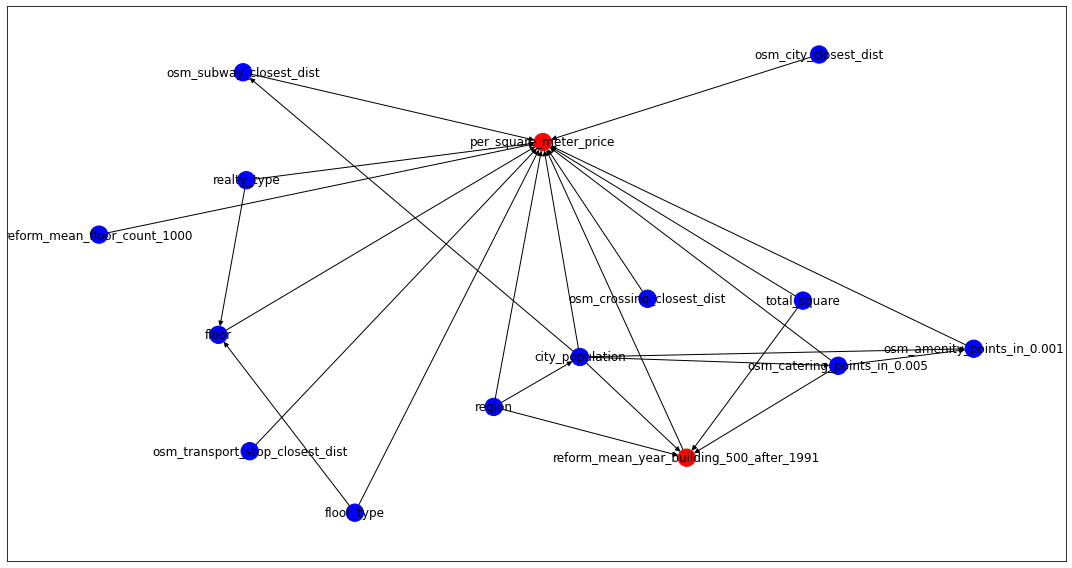

In [129]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=nx.spring_layout(graph), node_color=color_map)
plt.tight_layout()

In [132]:
dataset = dataset.loc[:, feature_columns + [treatment] + [target]]

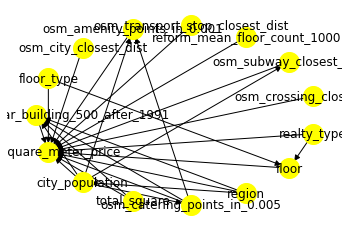

In [133]:
model = CausalModel(
    data=dataset,
    treatment=treatment,
    outcome=target,
    graph=" ".join(nx.generate_gml(graph))
)

model.view_model()

### Step 2. Identification (formulating what to estimate)

In [134]:
%%time

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                        
───────────────────────────────────────────(Expectation(per_square_meter_price
d[reform_mean_year_building_500_after_1991]                                   

                                                                              
|osm_catering_points_in_0.005,osm_amenity_points_in_0.001,region,osm_city_clos
                                                                              

                                                                              
est_dist,realty_type,city_population,osm_transport_stop_closest_dist,floor,osm
                                                                              

                                                                              
_crossing_closest_dist,floor_type,total_square,osm_subway_closest_dist,reform_
                                

### Step 3. Estimation (compute the estimate)

In [149]:
%%time

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="ate",
)
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                        
───────────────────────────────────────────(Expectation(per_square_meter_price
d[reform_mean_year_building_500_after_1991]                                   

                                                                              
|osm_catering_points_in_0.005,osm_amenity_points_in_0.001,region,osm_city_clos
                                                                              

                                                                              
est_dist,realty_type,city_population,osm_transport_stop_closest_dist,floor,osm
                                                                              

                                                                              
_crossing_closest_dist,floor_type,total_square,osm_subway_close

In [140]:
# Вывод: Если дома в радиусе 500 метров в среднем построены позже 1991,
# то это отрицательно влияет на стоимость квадратного метра (цена уменьшается)

### Refute

In [151]:
%%time
# Добавим случайную общую причину для reform_mean_year_building_500_after_1991 и per_square_meter_price,
# чтобы оценить ее влияние на полученную оценку

refute_results = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause",
    random_seed=0
)
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-28854.788995822175
New effect:-28853.952628461047

Wall time: 1.37 s


In [152]:
# Оценка не изменилась, значит мы правильно оценили эффекты влияния treatment на target и общей причины нет

In [156]:
%%time
# Заменим treatment независимой случайной величиной, чтобы проверить,
# является ли полученная нами изначальная оценка случайной

res_placebo = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="placebo_treatment_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-28854.788995822175
New effect:-21.923162880899145
p value:0.4895260587196145

Wall time: 8.34 s


In [ ]:
# Причинно-следственный эффект оказался незначительным с первоначальным,
# значит наша оценка влияния treatment на target состоятельна

In [159]:
%%time
# Заменим таргет независимой случайной величиной. Если наша первоначальная оценка причинно-следственного эффекта неверна,
# то мы получим значительный эффект

res_dummy = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="dummy_outcome_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_dummy[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0009405882072132277
p value:0.4276298511623757

Wall time: 7.22 s


In [ ]:
# Полученный причинно-следственный эффект оказался близок к нулю, значит наша оценка влияния treatment на target состоятельна

In [158]:
%%time
# Заменим набор данных случайным выбранным подмножеством и проверим изменится оценочный эффект

res_subset = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.9, 
    num_simulations=5,
    random_state=0,
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-28854.788995822175
New effect:-31326.353135055873
p value:0.0

Wall time: 8.55 s


C:\Users\Sasha\AppData\Roaming\Python\Python38\site-packages\dowhy\causal_refuter.py:201: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (estimate.value - mean_refute_values)/ std_dev_refute_values


In [ ]:
# Эффект изменился в разумных пределах, значит наша оценка влияния treatment на target состоятельна